# ARIM情報活用講座：　
# 論文：Prediction of organic compound aqueous solubility using machine learning  
### Part-2 (Morganフィンガープリント)

Tayyebi, A., Alshami, A.S., Rabiei, Z. et al. Prediction of organic compound aqueous solubility using machine learning: a comparison study of descriptor-based and fingerprints-based models. J Cheminform 15, 99 (2023).   
https://doi.org/10.1186/s13321-023-00752-6

# Google Colabにおける環境設定
google colab環境でなければ実行不要

In [ ]:
!pip install rdkit-pypi
!pip install shap
!git clone https://github.com/ARIM-Training/Training_python_12.git
%cd Training_python_12

## 1.データの読み込み
### 汎用ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#importing rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw

# 警告を無視
from warnings import filterwarnings
filterwarnings('ignore')

### データセットファイルの読み込み
Part-1と同じくnew222new.csvを読み出してデータフレーム型のsol変数とします。

In [2]:
sol = pd.read_csv('data/new222new.csv')
sol

,SMILES,measured log(solubility:mol/L)
0,OCC1OC(CO)(OC2OC(CO)C(O)C(O)C2O)C(O)C1O,0.79
1,O[C@H]1[C@H](O[C@H](CO)[C@@H](O)[C@@H]1O)O[C@]...,0.79
2,OC[C@@H]1O[C@](CO)(O[C@@H]2O[C@@H](CO)[C@H](O)...,0.79
3,CN1C[C@@H]2C[C@@H](C1)C3=CC=CC(=O)N3C2,0.65
4,CN1CC2CC(C1)C1=CC=CC(=O)N1C2,0.65
...,...,...
8433,O=[N+]([O-])C,0.26
8434,OC,1.57
8435,S=C(N)N,0.32
8436,O=C(NO)N,1.12


In [3]:
XY = sol.set_index('SMILES').T.to_dict('list')

{'OCC1OC(CO)(OC2OC(CO)C(O)C(O)C2O)C(O)C1O': [0.79],
 'O[C@H]1[C@H](O[C@H](CO)[C@@H](O)[C@@H]1O)O[C@]1(CO)O[C@H](CO)[C@@H](O)[C@@H]1O': [0.79],
 'OC[C@@H]1O[C@](CO)(O[C@@H]2O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]2O)[C@H](O)[C@H]1O': [0.79],
 'CN1C[C@@H]2C[C@@H](C1)C3=CC=CC(=O)N3C2': [0.65],
 'CN1CC2CC(C1)C1=CC=CC(=O)N1C2': [0.65],
 'NCCNCCNCCN.NCCN(CCN)CCN': [0.53],
 'CN(C)C(=O)C1=C(C=CC=C1)C(=O)N(C)C': [0.51],
 'CN(C)C(=O)C1=CC(=CC=C1)C(=O)N(C)C': [0.49],
 'OCC1OC(OCC2OC(O)C(O)C(O)C2O)C(O)C(O)C1O': [0.47],
 'OCC1OC(OCC(O)C(O)C(O)C(O)C=O)C(O)C(O)C1O': [0.47],
 'OC1=CC2=C(C=C1)S(=O)(=O)C1=CC=CC=C1S2(=O)=O': [0.42],
 'OC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O)[C@H](O)O[C@@H]2CO)[C@H](O)[C@@H](O)[C@@H]1O': [0.36],
 'OCC(O)C(OC1OC(CO)C(O)C(O)C1O)C(O)C(=O)CO': [0.35],
 'OC[C@H]1O[C@](O)(CO)[C@@H](O)C1O[C@@H]1O[C@H](CO)[C@H](O)[C@H](O)[C@@H]1O': [0.35],
 'OC[C@H]1O[C@@H](O[C@@H]2[C@@H](CO)O[C@](O)(CO)[C@H]2O)[C@H](O)[C@@H](O)[C@H]1O': [0.35],
 'O=P(N1CCOCC1)(N1CCOCC1)N1CCOCC1': [0.3],
 'CCOP(=O)(OCC)

In [4]:
y = sol.iloc[:,1]
y

0       0.79
1       0.79
2       0.79
3       0.65
4       0.65
        ... 
8433    0.26
8434    1.57
8435    0.32
8436    1.12
8437    0.96
Name: measured log(solubility:mol/L), Length: 8438, dtype: float64

## 2. Morganフィンガープリント

### SMILESからのハッシュ化
8438の化合物のSMILES構造からMolオブジェクトを生成します。具体的には、['SMILES']列に`MolFromSmiles`メソッドを適用し、新たに生成されたMolオブジェクトを`AllChem.GetMorganFingerprintAsBitVect()`メソッドにforループで逐次的に処理を進めます。ここでは半径2、ビット数2,048で行われます。

In [ ]:
X = []

for smile, Hlist in XY.items():
    try:
        X.append(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), radius=2,nBits = 2048))

    except:
        pass

X = [list(a) for a in X]

In [ ]:
print(len(X))

### 特徴量の刈り込み
特徴量の刈り込みは、ハッシュ値がゼロのビット（ゼロビット）を排除します。その方法はLassoを使って重み係数がゼロの項目を排除する性質を利用して行います。LASSOのハイパーパラメータであるalpha値は0.001としています。

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

In [ ]:
x = X

# Fit a LASSO regression model on the fingerprints and target variable
reg = Lasso(alpha=0.001)
reg.fit(x, y)

nonzero_indices = [i for i, coef in enumerate(reg.coef_) if coef != 0]

for i in nonzero_indices:
    print("Bit", i, ":", reg.coef_[i])

# Select the columns with nonzero coefficients from the x array
x_nonzero = [[row[i] for i in nonzero_indices] for row in x]

In [ ]:
print(len(nonzero_indices))

In [ ]:
X_prune = x_nonzero
print(len(X_prune))

## ２.機械学習モデリング
機械学習モデリングは線形重線形回帰 (MLR) とランダムフォレスト（RF）の二つのアルゴリズムで検討をしています。
説明変数は、上記で作成したMorganフィンガープリント（X）です。対して、目的変数は水溶解度で、最初に読み込ませたsolの2列目をYとして定義します。

## Case1: 631ビット

### データセットの分割（Data set splitting）
分割は`test_size=0.2`として訓練データ：0.8、テストデータ：0.2としています。

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_prune, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=991
                                                   )

### 2-1.線形重回帰 (MLR) 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
linearmodel=LinearRegression()
linearmodel.fit(X_train, Y_train)

### R2スコア

In [ ]:
#predicts the X_train
Y_pred_train = linearmodel.predict(X_train)

print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train,squared=False))

print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

In [ ]:
#predicts the X_test
Y_pred_test = linearmodel.predict(X_test)

print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test,squared=False))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

### MAE

In [ ]:
mae = mean_absolute_error(Y_train, Y_pred_train)
print('Training MAE : {:.3f}'.format(mae))

In [ ]:
mae = mean_absolute_error(Y_test, Y_pred_test)
print('Test MAE : {:.3f}'.format(mae))

### RMSE

In [ ]:
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
print('Training RMSE : {:.3f}'.format(rmse))

In [ ]:
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
print('Test RMSE : {:.3f}'.format(rmse))

### Exp-Predict Plot

In [ ]:
#Vertical plot
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=1)

# Add trendline
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS', fontsize=13)
plt.ylabel('Predicted LogS', fontsize=13)


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=1)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS', fontsize=13)
plt.xlabel('Experimental LogS', fontsize=13)

# 出力
#plt.savefig('output/plot_vertical_logS_ECFP_MLR.png')
#plt.savefig('output/paper logS descriptor_ECFP_MLR.pdf',dpi=300)

plt.show()

### 2-2.ランダムフォレスト回帰（RFR）

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

### R2スコア

In [ ]:
#predicts the X_train
Y_pred_train = model.predict(X_train)

print('Mean squared error (MSE): %.3f'
      % mean_squared_error(Y_train, Y_pred_train,squared=False))

print('Coefficient of determination (R^2): %.3f'
      % r2_score(Y_train, Y_pred_train))

In [ ]:
Y_pred_test = model.predict(X_test)

print('Mean squared error (MSE): %.3f'
      % mean_squared_error(Y_test, Y_pred_test,squared=False))

print('Coefficient of determination (R^2): %.3f'
      % r2_score(Y_test, Y_pred_test))

### MAE

In [ ]:
mae = mean_absolute_error(Y_train, Y_pred_train)
print('Training MAE : {:.3f}'.format(mae))

In [ ]:
mae = mean_absolute_error(Y_test, Y_pred_test)
print('Test MAE : {:.3f}'.format(mae))

### RMSE

In [ ]:
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
print('Training RMSE : {:.3f}'.format(rmse))

In [ ]:
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
print('Test RMSE : {:.3f}'.format(rmse))

### Exp-Predict Plot

In [ ]:
#Vertical plot
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=1)

# Add trendline
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS', fontsize=13)
plt.ylabel('Predicted LogS', fontsize=13)


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=1)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS', fontsize=13)
plt.xlabel('Experimental LogS', fontsize=13)

# 出力
#plt.savefig('output/plot_vertical_logS_ECFP_RFR.png')
#plt.savefig('output/paper logS descriptor_ECFP_RFR.pdf',dpi=300)

plt.show()

## Case2: 2048ビット
ここでは枝狩りをしていない2048ビットを特徴量としたときの精度も比較考証をしています。

### データセットの分割（Data set splitting）

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=991
                                                   )

### 2-3.線形重回帰 (MLR) 

In [ ]:
linearmodel=LinearRegression()
linearmodel.fit(X_train, Y_train)

### R2スコア

In [ ]:
#predicts the X_train
Y_pred_train = linearmodel.predict(X_train)

print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train,squared=False))

print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

In [ ]:
#predicts the X_test
Y_pred_test = reg.predict(X_test)

print('Mean squared error (MSE): %.3f'
      % mean_squared_error(Y_test, Y_pred_test,squared=False))

print('Coefficient of determination (R^2): %.3f'
      % r2_score(Y_test, Y_pred_test))

### MAE

In [ ]:
mae = mean_absolute_error(Y_train, Y_pred_train)
print('Training MAE : {:.3f}'.format(mae))

In [ ]:
mae = mean_absolute_error(Y_test, Y_pred_test)
print('Test MAE : {:.3f}'.format(mae))

### RMSE

In [ ]:
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
print('Training RMSE : {:.3f}'.format(rmse))

In [ ]:
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
print('Test RMSE : {:.3f}'.format(rmse))

### Exp-Predict Plot

In [ ]:
#Vertical plot
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=1)

# Add trendline
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS', fontsize=13)
plt.ylabel('Predicted LogS', fontsize=13)


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=1)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS', fontsize=13)
plt.xlabel('Experimental LogS', fontsize=13)

# 出力
#plt.savefig('output/plot_vertical_logS_ECFP__MLR_2048.png')
#plt.savefig('output/paper logS ECFP__MLR_2048.pdf',dpi=300)

plt.show()

### 係数の出力

In [ ]:
# Print out the coefficients for each fingerprint
for i in range(len(X[0])):
    print("Bit", i, ":", reg.coef_[i])

In [ ]:
import csv
with open('output/coefficients.csv', mode='w') as file:
    writer = csv.writer(file)
    for i in range(len(X[0])):
        writer.writerow(['Bit ' + str(i), reg.coef_[i]])

### 2-4.ランダムフォレスト回帰（RFR）

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

### R2スコア

In [ ]:
#predicts the X_train
Y_pred_train = model.predict(X_train)

print('Mean squared error (RMSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train,squared=False))

print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))


In [ ]:
Y_pred_test = model.predict(X_test)

print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test,squared=False))

print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

### MAE

In [ ]:
mae = mean_absolute_error(Y_train, Y_pred_train)
mae

In [ ]:
mae = mean_absolute_error(Y_test, Y_pred_test)
mae

### RMSE

In [ ]:
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
print('Training RMSE : {:.3f}'.format(rmse))

In [ ]:
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
print('Test RMSE : {:.3f}'.format(rmse))

### Exp-Predict Plot

In [ ]:
#Vertical plot
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=1)

# Add trendline
# https://stackoverflow.com/questions/26447191/how-to-add-trendline-in-python-matplotlib-dot-scatter-graphs
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")


plt.xlabel('Experimental LogS',fontsize=13)
plt.ylabel('Predicted LogS',fontsize=13)


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=1)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS',fontsize=13)
plt.xlabel('Experimental LogS',fontsize=13)

# 出力
#plt.savefig('plot_vertical_logS.png')
#plt.savefig('output/paper logS morgan_ECFP_2048_RF.pdf',dpi=300)

plt.show()

### 3. SHAP計算

In [ ]:
import shap
from sklearn.preprocessing import StandardScaler

In [ ]:
%%time

X = X_test
Xscaler = StandardScaler()
X2= Xscaler.fit_transform(X)

explainer = shap.TreeExplainer(model,data=X2,
                               feature_perturbation='interventional'
                              )

shap_values = explainer.shap_values(X2)

### beeswarm plot

In [ ]:
shap.summary_plot(shap_values, 
                  X2, 
                  plot_type="dot", 
                  plot_size=0.6, 
                  show=False,
                  max_display=12
                 )

### Global bar plot

In [ ]:
shap.summary_plot(shap_values, 
                  max_display=12, 
                  plot_type="bar",
                  show=False
                 )

### 係数の出力

In [ ]:
vals= np.abs(shap_values).mean(0)

i=12

feature_importance = pd.DataFrame(list(zip(X2[i], vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance[:12]

In [ ]:
feature_importance.to_excel(r'output/File Name44.xlsx', index = False)

### 4.ブラインドテスト
Additional Fileとして提供されているtestexperiment2upload3raw.csvでの事例です。

### ブラインドテスト 1

In [ ]:
#Blind test
sol2 = pd.read_csv('data/testexperiment2upload3raw.csv')
print(sol2.head)
XY2 = sol2.set_index('SMILES').T.to_dict('list')

In [ ]:
X3 = []

for smile, Hlist in XY2.items():
    try:
        X3.append(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), radius=2,nBits = 2048))

    except:
        pass
    
X3 = [list(c) for c in X3]
print(len(X3))

In [ ]:
Xnew=X3
ynew = model.predict(Xnew)
ynew

### ブラインドテスト 2

In [ ]:
#Solubility Challenge
sol3 = pd.read_csv('data/testexperiment2upload2raw.csv')
print(sol3.head)
XY3 = sol3.set_index('SMILES').T.to_dict('list')

In [ ]:
X4 = []

for smile, Hlist in XY3.items():
    try:
        X4.append(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), radius=2,nBits = 2048))

    except:
        pass
X4 = [list(c) for c in X4]
print(len(X4))

In [ ]:
X2new=X4
y2new = model.predict(X2new)
y2new

### 予測値の出力保存

In [ ]:
# define data
data = np.asarray(ynew)

# save to csv file
np.savetxt('output/data_ECFP.csv', data, delimiter=',')

### 可視化

In [5]:
from rdkit.Chem import rdMolDescriptors

In [6]:
z = sol.iloc[:,0]
z

0                 OCC1OC(CO)(OC2OC(CO)C(O)C(O)C2O)C(O)C1O
1       O[C@H]1[C@H](O[C@H](CO)[C@@H](O)[C@@H]1O)O[C@]...
2       OC[C@@H]1O[C@](CO)(O[C@@H]2O[C@@H](CO)[C@H](O)...
3                  CN1C[C@@H]2C[C@@H](C1)C3=CC=CC(=O)N3C2
4                            CN1CC2CC(C1)C1=CC=CC(=O)N1C2
                              ...                        
8433                                        O=[N+]([O-])C
8434                                                   OC
8435                                              S=C(N)N
8436                                             O=C(NO)N
8437                                              O=C(N)N
Name: SMILES, Length: 8438, dtype: object

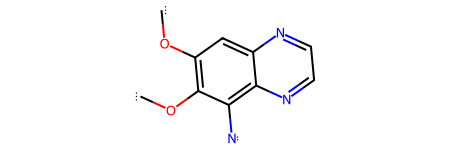

In [15]:
w = Chem.MolFromSmiles(z[1814])
w

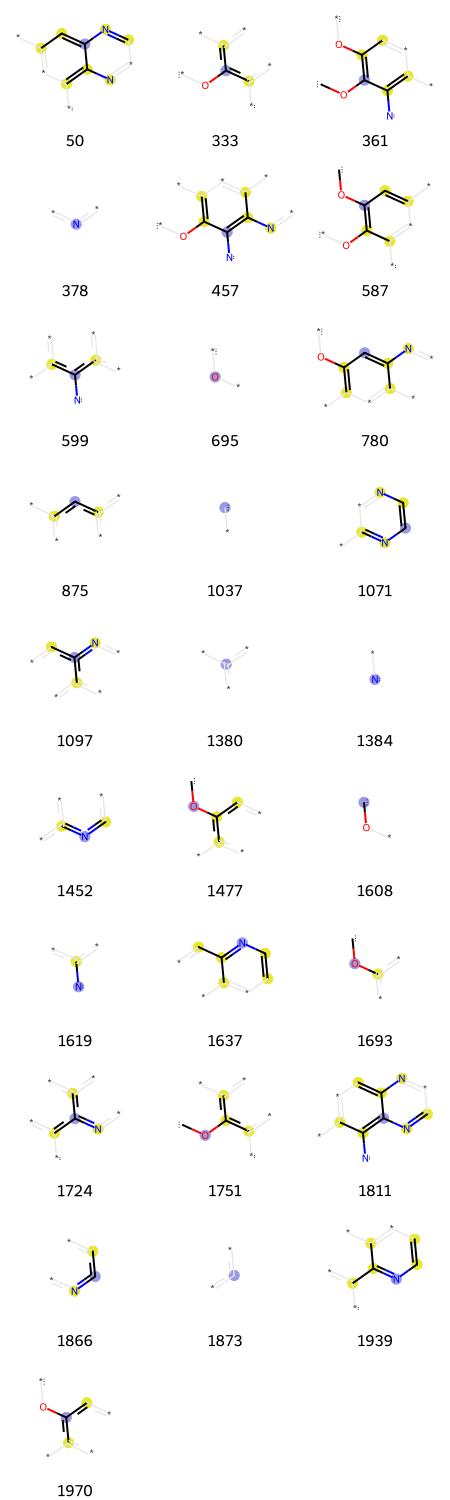

In [16]:
bi = {}

fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(w, 
                                                    radius=2, 
                                                    bitInfo=bi, 
                                                    nBits = 2048
                                                   )

tpls = [(w,x,bi) for x in fp.GetOnBits()]

p = Draw.DrawMorganBits(tpls[:],
                        molsPerRow=3,
                        legends=[str(x) for x in fp.GetOnBits()][:]
                       )
p

### 【参考】 Figure2の作成

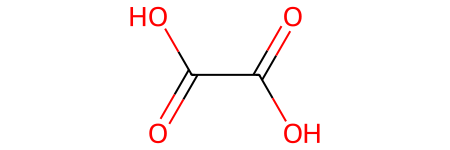

In [19]:
w = Chem.MolFromSmiles(z[8402])
w

In [23]:
bi_bz = {}
fp_bz = AllChem.GetMorganFingerprintAsBitVect(w,
                                              radius=2,
                                              nBits=2048,
                                              bitInfo=bi_bz)

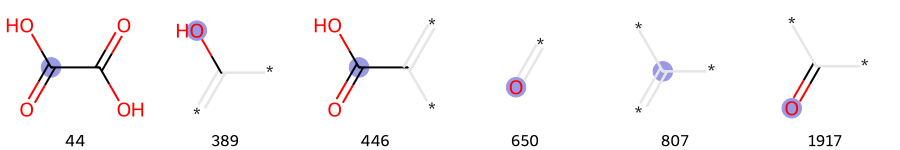

In [25]:
tpls = [(w,x,bi_bz) for x in fp_bz.GetOnBits()]

p = Draw.DrawMorganBits(tpls[:],
                        molsPerRow=6,
                        legends=[str(x) for x in fp_bz.GetOnBits()][:]
                       )
p